In [2]:
# ATTENTION: Please do not alter any of the provided code in the exercise. Only add your own code where indicated
# ATTENTION: Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position.
# ATTENTION: Please use the provided epoch values when training.

import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from os import getcwd

embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [3]:

# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv

path_training_cleaned = f"{getcwd()}/../tmp2/training_cleaned.csv"

num_sentences = 0

with open(path_training_cleaned) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], 
      # and the second is the label. Note that the label is a '0' or a '4' in the text. 
      # When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        # YOUR CODE HERE
        if (row[0] == "0"):
            list_item = [row[5], 0]
        elif (row[0] == "4"):
            list_item = [row[5], 1]
        else:
            print(row[0])
        num_sentences = num_sentences + 1
        corpus.append(list_item)




In [4]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [5]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])# YOUR CODE HERE)
    labels.append(corpus[x][1])# YOUR CODE HERE)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)# YOUR CODE HERE)

word_index = tokenizer.word_index
vocab_size=len(word_index)# YOUR CODE HERE)

sequences = tokenizer.texts_to_sequences(sentences) # YOUR CODE HERE)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)# YOUR CODE HERE)

split = int(test_portion * training_size)

test_sequences = padded[0:split]# YOUR CODE HERE]
training_sequences = padded[split:training_size]# YOUR CODE HERE]
test_labels = labels[0:split]# YOUR CODE HERE]
training_labels = labels[split:training_size]# YOUR CODE HERE]

In [6]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138447
1


In [7]:
# Note this is the 100 dimension version of GloVe from Stanford
path_glove = f"{getcwd()}/../tmp2/glove.6B.100d.txt"
embeddings_index = {};
with open(path_glove) as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [8]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138448


In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])# YOUR CODE HERE)
model.summary()


history = model.fit(training_sequences, 
                    np.array(training_labels), 
                    epochs=15,
                    batch_size=128, 
                    validation_data=(test_sequences, np.array(test_labels)), 
                    verbose=1)

print("Training Complete")


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 16, 100)           13844800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 13,909,953
Trainable params: 65,153
Non-trainable params: 13,844,800
_____________________________________

<Figure size 432x288 with 0 Axes>

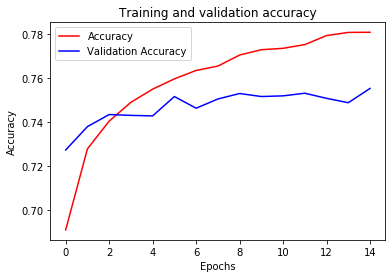

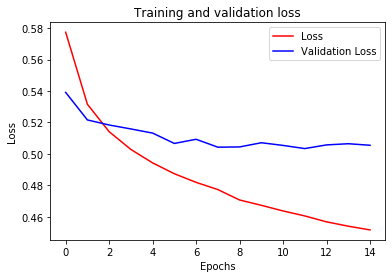

<Figure size 432x288 with 0 Axes>

In [18]:
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

In [19]:
# Now click the 'Submit Assignment' button above.
# Once that is complete, please run the following two cells to save your work and close the notebook

In [20]:
%%javascript
<!-- Save the notebook -->
IPython.notebook.save_checkpoint();

<IPython.core.display.Javascript object>

In [ ]:
%%javascript
IPython.notebook.session.delete();
window.onbeforeunload = null
setTimeout(function() { window.close(); }, 1000);